<a href="https://colab.research.google.com/github/EliseoCabana/Modelo_PLN_Regresion/blob/main/Proyecto_M7_An%C3%A1lisis_de_Sentimientos_y_Predicci%C3%B3n_de_Calificaciones_de_Apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto M7: Análisis de Sentimientos y Predicción de Calificaciones de Apps**

## **IMPORTANDO LIBRERÍAS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
import re                         # expresiones regulares
import spacy                      # pnl
import string                     # tipo string

from tensorflow import keras

Mounted at /content/drive


## **LIMPIEZA DE DATOS**

### *DATA 1: GOOGLE PLAY STORE*

In [ ]:
# Subimos la primera base
data1= pd.read_csv('/content/drive/MyDrive/ESPECIALIZACIÓN EN IA Y CIENCIA DE DATOS/PROYECTOS/M7/googleplaystore.csv')
data1.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
# vemos informacion de la data
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [ ]:
# Eliminamos duplicados
print(data1.duplicated().sum())
data1.drop_duplicates(inplace=True)
print(data1.duplicated().sum())

483
0


In [ ]:
# Eliminamos columnas que no trabajaremos
data1.drop(columns={'Genres','Current Ver','Android Ver'},inplace= True)
data1.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Last Updated'],
      dtype='object')

In [ ]:
# Limpiamos la columna RATING
data1= data1[data1['Rating']!=19]
data1= data1[data1['Rating'].notnull()]
print(data1['Rating'].unique())

[4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.2 4.6 3.2 4.  4.8 4.9 3.6 3.7 3.3 3.4 3.5
 3.1 5.  2.6 3.  1.9 2.5 2.8 2.7 1.  2.9 2.3 2.2 1.7 2.  1.8 2.4 1.6 2.1
 1.4 1.5 1.2]


In [ ]:
# Limpiamos la columna Size
print(data1['Size'].unique())

data1['M']= np.where(data1['Size'].str.contains('M')>=1,data1['Size'],0)
data1['K']= np.where(data1['Size'].str.contains('k')>=1,data1['Size'],0)

data1['M']= data1['M'].str.replace('M','').astype(float)

data1['K']= data1['K'].str.replace('k','')
data1['K']=data1['K'].astype(float)
data1['K']= data1['K']/1024


data1['Size']= np.where(data1['Size'].str.contains('M')>=1,data1['M'],data1['K'])
data1['Size']= round(data1['Size'],1)
data1.drop(columns={'M','K'},inplace=True)
print(data1['Size'].unique())

['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '23M' '6.0M'
 '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device' '9.4M' '15M'
 '10M' '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M' '201k' '3.6M'
 '5.7M' '8.6M' '2.4M' '27M' '2.5M' '7.0M' '16M' '3.4M' '8.9M' '3.9M'
 '2.9M' '38M' '32M' '5.4M' '18M' '1.1M' '2.2M' '4.5M' '9.8M' '52M' '9.0M'
 '6.7M' '30M' '2.6M' '7.1M' '22M' '6.4M' '3.2M' '8.2M' '4.9M' '9.5M'
 '5.0M' '5.9M' '13M' '73M' '6.8M' '3.5M' '4.0M' '2.3M' '2.1M' '42M' '9.1M'
 '55M' '23k' '7.3M' '6.5M' '1.5M' '7.5M' '51M' '41M' '48M' '8.5M' '46M'
 '8.3M' '4.3M' '4.7M' '3.3M' '40M' '7.8M' '8.8M' '6.6M' '5.1M' '61M' '66M'
 '79k' '8.4M' '3.7M' '118k' '44M' '695k' '1.6M' '6.2M' '53M' '1.4M' '3.0M'
 '7.2M' '5.8M' '3.8M' '9.6M' '45M' '63M' '49M' '77M' '4.4M' '70M' '9.3M'
 '8.1M' '36M' '6.9M' '7.4M' '84M' '97M' '2.0M' '1.9M' '1.8M' '5.3M' '47M'
 '556k' '526k' '76M' '7.6M' '59M' '9.7M' '78M' '72M' '4

In [ ]:
# Limpiamos la columna Price
print(data1['Price'].unique())

data1['Price']= data1['Price'].str.replace('$','').astype(float)
print(data1['Price'].unique())

['0' '$4.99' '$3.99' '$6.99' '$7.99' '$5.99' '$2.99' '$3.49' '$1.99'
 '$9.99' '$7.49' '$0.99' '$9.00' '$5.49' '$10.00' '$24.99' '$11.99'
 '$79.99' '$16.99' '$14.99' '$29.99' '$12.99' '$2.49' '$10.99' '$1.50'
 '$19.99' '$15.99' '$33.99' '$39.99' '$3.95' '$4.49' '$1.70' '$8.99'
 '$1.49' '$3.88' '$399.99' '$17.99' '$400.00' '$3.02' '$1.76' '$4.84'
 '$4.77' '$1.61' '$2.50' '$1.59' '$6.49' '$1.29' '$299.99' '$379.99'
 '$37.99' '$18.99' '$389.99' '$8.49' '$1.75' '$14.00' '$2.00' '$3.08'
 '$2.59' '$19.40' '$3.90' '$4.59' '$15.46' '$3.04' '$13.99' '$4.29'
 '$3.28' '$4.60' '$1.00' '$2.95' '$2.90' '$1.97' '$2.56' '$1.20']
[  0.     4.99   3.99   6.99   7.99   5.99   2.99   3.49   1.99   9.99
   7.49   0.99   9.     5.49  10.    24.99  11.99  79.99  16.99  14.99
  29.99  12.99   2.49  10.99   1.5   19.99  15.99  33.99  39.99   3.95
   4.49   1.7    8.99   1.49   3.88 399.99  17.99 400.     3.02   1.76
   4.84   4.77   1.61   2.5    1.59   6.49   1.29 299.99 379.99  37.99
  18.99 389.99   8.49   1

<ipython-input-50-b039e44bd4db>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data1['Price']= data1['Price'].str.replace('$','').astype(float)


In [ ]:
# Limpiamos la columna Las Updated
print(data1['Last Updated'].unique())
data1['Last Updated']= pd.to_datetime(data1['Last Updated'])
data1['day_updated'] = (datetime.now() - pd.to_datetime(data1['Last Updated'])).dt.days

data1.drop(columns={'Last Updated'},inplace= True)
print(data1['day_updated'].unique())

['January 7, 2018' 'January 15, 2018' 'August 1, 2018' ...
 'January 20, 2014' 'February 16, 2014' 'March 23, 2014']
[2199 2191 1993 ... 3647 3620 3585]


In [ ]:
# Terminamos de limpiar
data1['Reviews']= data1['Reviews'].astype(int)

In [ ]:
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8892 entries, 0 to 10840
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8892 non-null   object 
 1   Category        8892 non-null   object 
 2   Rating          8892 non-null   float64
 3   Reviews         8892 non-null   int64  
 4   Size            7424 non-null   float64
 5   Installs        8892 non-null   object 
 6   Type            8892 non-null   object 
 7   Price           8892 non-null   float64
 8   Content Rating  8892 non-null   object 
 9   day_updated     8892 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 764.2+ KB


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,day_updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,0.0,Everyone,2199
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0.0,Everyone,2191
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,0.0,Everyone,1993
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,0.0,Teen,2047
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,0.0,Everyone,2035


### *DATA 2: USER REVIEWS*

In [ ]:
# Subimos la segunda data
data2= pd.read_csv('/content/drive/MyDrive/ESPECIALIZACIÓN EN IA Y CIENCIA DE DATOS/PROYECTOS/M7/googleplaystore_user_reviews.csv')
data2.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [ ]:
# Eliminamos columnas que no necesitamos
data2.drop(columns={'Sentiment_Polarity','Sentiment_Subjectivity'},inplace= True)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   App                64295 non-null  object
 1   Translated_Review  37427 non-null  object
 2   Sentiment          37432 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [ ]:
# Eliminamos vacios de etiqueta de sentimientos y Texto
data2= data2[(data2['Sentiment'].notnull())&(data2['Translated_Review'].notnull())]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   App                37427 non-null  object
 1   Translated_Review  37427 non-null  object
 2   Sentiment          37427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [ ]:
# Creamos un data secundaria para el cruce con Data 1.
data_review= data2.groupby(['App', 'Sentiment']).size().unstack(fill_value=0).reset_index()
data_review

Sentiment,App,Negative,Neutral,Positive
0,10 Best Foods for You,10,22,162
1,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,1,8,31
2,11st,7,9,23
3,1800 Contacts - Lens Store,6,10,64
4,1LINE – One Line with One Touch,8,3,27
...,...,...,...,...
860,Hotels.com: Book Hotel Rooms & Find Vacation D...,21,8,39
861,Hotspot Shield Free VPN Proxy & Wi-Fi Security,3,14,17
862,Hotstar,14,4,14
863,Hotwire Hotel & Car Rental App,6,11,16


## **ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

In [ ]:
# Variable Objetivo
data1['Rating'].describe().T

count    8892.000000
mean        4.187877
std         0.522377
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

In [ ]:
# Merge de data
data1['App']= data1['App'].str.strip()
data_review['App']= data_review['App'].str.strip()
data_comb= pd.merge(data1,data_review,on='App', how='left')
data_comb= data_comb[data_comb['Positive'].notnull()]
data_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1078 entries, 1 to 8807
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1078 non-null   object 
 1   Category        1078 non-null   object 
 2   Rating          1078 non-null   float64
 3   Reviews         1078 non-null   int64  
 4   Size            723 non-null    float64
 5   Installs        1078 non-null   object 
 6   Type            1078 non-null   object 
 7   Price           1078 non-null   float64
 8   Content Rating  1078 non-null   object 
 9   day_updated     1078 non-null   int64  
 10  Negative        1078 non-null   float64
 11  Neutral         1078 non-null   float64
 12  Positive        1078 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 117.9+ KB


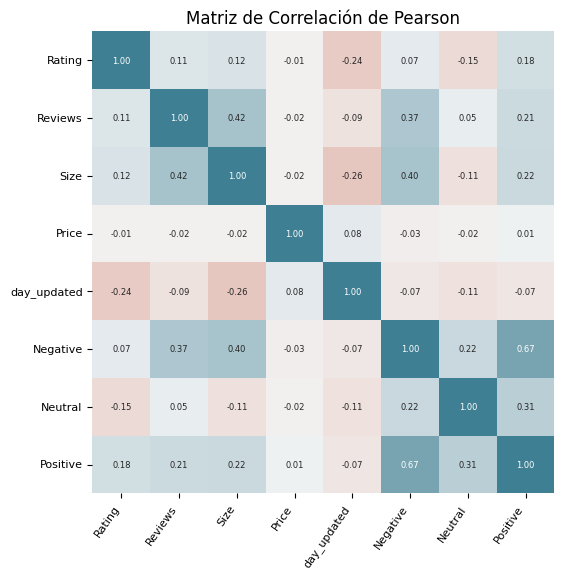

In [ ]:
corr_matrix= data_comb.select_dtypes(include=['float64','int']).corr(method='pearson')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sn.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sn.diverging_palette(20, 220, n=200),
    fmt=".2f",
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 55,
    horizontalalignment = 'right',
)
ax.set_title('Matriz de Correlación de Pearson')
ax.tick_params(labelsize = 8)

## **PREPROCESAMIENTO DE DATOS**

### *DATA 1*

In [ ]:
# Completitud de Size
data1_preproc= data1.drop(columns={'App'})
data1_preproc['Size']= data1_preproc['Size'].fillna(data1_preproc['Size'].median())
data1_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8892 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        8892 non-null   object 
 1   Rating          8892 non-null   float64
 2   Reviews         8892 non-null   int64  
 3   Size            8892 non-null   float64
 4   Installs        8892 non-null   object 
 5   Type            8892 non-null   object 
 6   Price           8892 non-null   float64
 7   Content Rating  8892 non-null   object 
 8   day_updated     8892 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 694.7+ KB


In [ ]:
# Codificando variables categóricas con One-Hot-Encoding
data1_preproc = pd.get_dummies(data1_preproc, columns=['Category', 'Installs','Type','Content Rating'])
data1_preproc

,Rating,Reviews,Size,Price,day_updated,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,"Installs_500,000+","Installs_500,000,000+",Type_Free,Type_Paid,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4.1,159,19.0,0.0,2199,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,3.9,967,14.0,0.0,2191,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,4.7,87510,8.7,0.0,1993,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,4.5,215644,25.0,0.0,2047,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,4.3,967,2.8,0.0,2035,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,4.0,7,2.6,0.0,2402,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
10836,4.5,38,53.0,0.0,2365,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
10837,5.0,4,3.6,0.0,2019,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
10839,4.5,114,14.0,0.0,3283,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


### DATA 2: USER REVIES

<ipython-input-81-baedef8a453a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grafico_data['Sentiment']= grafico_data['Sentiment'].replace({0:'Negative',4:'Positive',2:'Neutral'})


Text(0, 0.5, 'Cantidad')

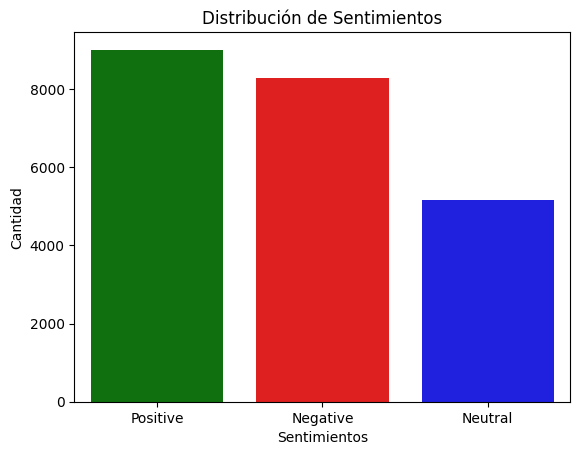

In [ ]:
# Realizamos un balanceo de datos
df_positivo = data2[data2['Sentiment'] == 'Positive']
df_negativo = data2[data2['Sentiment'] == 'Negative']
df_neutro = data2[data2['Sentiment'] == 'Neutral']
df_positivo_submuestreado = df_positivo.sample(n=9000, random_state=42)

df_submuestreado = pd.concat([df_positivo_submuestreado, df_negativo, df_neutro],ignore_index= True)

grafico_data= df_submuestreado[['Sentiment']]
grafico_data['Sentiment']= grafico_data['Sentiment'].replace({0:'Negative',4:'Positive',2:'Neutral'})
sn.countplot(x='Sentiment', data=grafico_data, palette={'Negative': 'red', 'Positive': 'green', 'Neutral': 'blue'})
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad')

In [ ]:
df_submuestreado

,App,Translated_Review,Sentiment
0,Apartments & Rentals - Zillow,I love zillow really need place apartment give...,Positive
1,Golden Launcher,Great app..Need update tho!! New version Pleas...,Positive
2,ColorNote Notepad Notes,"I started using Kindle Fire, I got smart phone...",Positive
3,DINO HUNTER: DEADLY SHORES,Well honest I really enjoy game however day tw...,Positive
4,ARY NEWS URDU,Headlines videos available previous version,Positive
...,...,...,...
22424,Hotwire Hotel & Car Rental App,Solid app. No issues yet. Been using year.,Neutral
22425,Hotwire Hotel & Car Rental App,"Keeps telling there's problem date time, can't...",Neutral
22426,Housing-Real Estate & Property,Why business? Your filters don't work.. redire...,Neutral
22427,Housing-Real Estate & Property,I want list property sale option. Please connect,Neutral


In [ ]:
# Proprocesamos la data
from tensorflow import keras
import nltk

# lematizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from nltk.corpus import stopwords
nltk.download('stopwords')
", ".join(stopwords.words('english'))
stop_words = set(stopwords.words('english'))

# tokenizar
from nltk.tokenize import word_tokenize
nltk.download('punkt')

transform_columns= ['Translated_Review']

def transformar(df,columns):
      for column in columns:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.lower() # todo a minúscula
        df[column] = df[column].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))# traemos las signos , esta ves eliminares todos porque no analizaremos sentimientos.
        df[column] = df[column].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words])) # eliminar stop words
        df[column] = df[column].apply(lambda text: word_tokenize(text)) # tokenizacion
        df[column] = df[column].apply(lambda tokens: ' '.join([WordNetLemmatizer().lemmatize(word) for word in tokens]))  # Lematizar
      return df

data2_prec= transformar(df_submuestreado, transform_columns)
data2_prec['Translated_Review'] = data2_prec['Translated_Review'].apply(lambda sentence: word_tokenize(sentence))
data2_prec.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,App,Translated_Review,Sentiment
0,Apartments & Rentals - Zillow,"[love, zillow, really, need, place, apartment,...",Positive
1,Golden Launcher,"[great, appneed, update, tho, new, version, pl...",Positive
2,ColorNote Notepad Notes,"[started, using, kindle, fire, got, smart, pho...",Positive
3,DINO HUNTER: DEADLY SHORES,"[well, honest, really, enjoy, game, however, d...",Positive
4,ARY NEWS URDU,"[headline, video, available, previous, version]",Positive


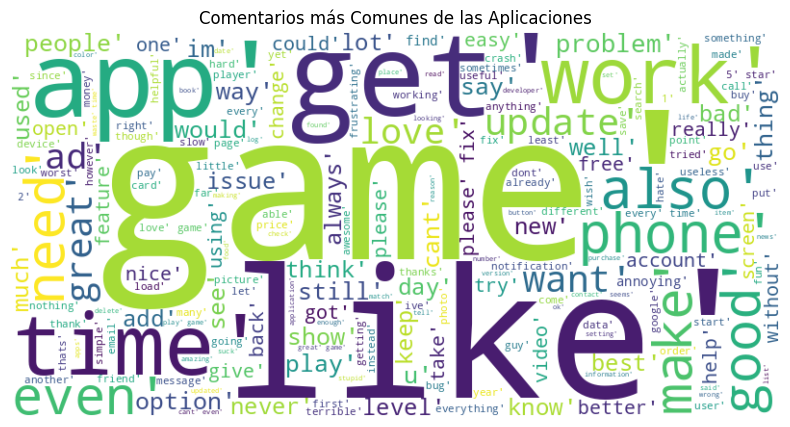

In [ ]:
# realizamos una nube de sentimientos
from wordcloud import WordCloud

textos_tuits = ' '.join(data2_prec['Translated_Review'].astype(str))

# Crear una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_tuits)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Comentarios más Comunes de las Aplicaciones')
plt.show()

In [ ]:
# Vectorización
